In [62]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers

import tensorflow_datasets as tfds

In [63]:
(train_data, test_data), ds_info = tfds.load(name="imdb_reviews", # target dataset to get from TFDS
        split=["train", "test"], # what splits of data should we get?
        shuffle_files=True, # shuffle files on download?
        as_supervised=True, # download data in tuple format (sample, label),
        with_info=True) # if so, tfds.load() returns tuple (data, ds_info)

In [64]:
ds_info.features


FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})

In [65]:
sample = train_data.take(1)
sample

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [66]:
for a, b in sample:
  label = b
  text = a.numpy().split()
  print(label, text)


tf.Tensor(0, shape=(), dtype=int64) [b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.', b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken', b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great', b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their', b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great', b'acting', b'could', b'not', b'redeem', b'this', b"movie's", b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an', b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The', b'most', b'pathetic', b'scenes', b'were', b'those', b'when', b'the', b'Columbian', b'rebels', b'were', b'making', b'their', b'cases', b'for', b'revolutions.', b'Maria', b'Conchita', b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love', b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a', b'pathetic', b'emotional', b'plug', b'in', b'a', b'movie', b'that', b'was', b'devoid', b'of', b'any', b'real', b'meaning.', b'I', b'am',

In [67]:
# Find average number of tokens (words) in training tensorflow dataset
round(sum([len(a.numpy().split()) for a, b in train_data])/len(train_data))



234

In [68]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [69]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=20000,
                                    output_mode="int",
                                    output_sequence_length=300)

In [70]:
text_vectorizer.adapt(train_data.map(lambda text, label: text))
len(text_vectorizer.get_vocabulary())

20000

In [71]:
embedding = layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()), # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             # input_length=234, # how long is each input
                             name="embedding_1") 

In [72]:
'''
model = tf.keras.Sequential([
     text_vectorizer,
     embedding,
     layers.Bidirectional(layers.LSTM(64)),
     layers.Dense(64, activation='relu'),
     layers.Dense(1) 
                             
])
'''

"\nmodel = tf.keras.Sequential([\n     text_vectorizer,\n     embedding,\n     layers.Bidirectional(layers.LSTM(64)),\n     layers.Dense(64, activation='relu'),\n     layers.Dense(1) \n                             \n])\n"

In [73]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 300, 128)
(None, 64)


In [74]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

In [75]:

## Callbacks

# End training if no improvement seen
early_stop_callbk = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

# Optimize LR
opt_LR_callbk = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2
)


In [76]:
history = model.fit(train_data, epochs=10,
                    validation_data=test_data,
                    validation_steps=30,
                    callbacks=[early_stop_callbk, opt_LR_callbk])

Epoch 1/10
391/391 [==============================] - 150s 376ms/step - loss: 0.6912 - accuracy: 0.5177 - val_loss: 0.6870 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 2/10
391/391 [==============================] - 175s 445ms/step - loss: 0.6522 - accuracy: 0.6087 - val_loss: 0.6648 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 3/10
391/391 [==============================] - 173s 440ms/step - loss: 0.6049 - accuracy: 0.6655 - val_loss: 0.6410 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 4/10
391/391 [==============================] - 171s 436ms/step - loss: 0.5647 - accuracy: 0.6856 - val_loss: 0.5583 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 5/10
391/391 [==============================] - 172s 440ms/step - loss: 0.3486 - accuracy: 0.8467 - val_loss: 0.3800 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 6/10
391/391 [==============================] - 172s 439ms/step - loss: 0.1922 - accuracy: 0.9307 - val_loss: 0.4012 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 7/10
391/391 [==========================

In [77]:
model.summary()


Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 300, 128)          2560000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

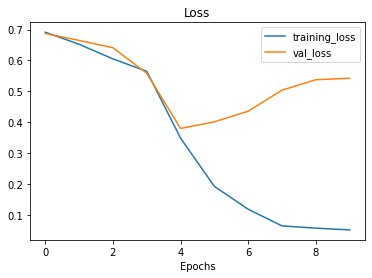

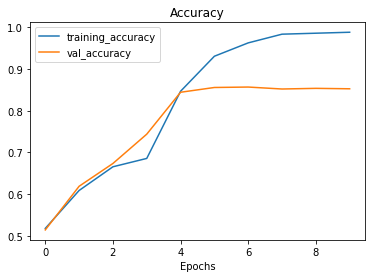

In [78]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

In [21]:
model.save('imbd_ltsm_class_1')

INFO:tensorflow:Assets written to: imbd_ltsm_class_1/assets


INFO:tensorflow:Assets written to: imbd_ltsm_class_1/assets


In [31]:
'''
model_url  = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

import tensorflow_hub as hub
feature_extractor_layer = hub.KerasLayer(model_url,
         input_shape=[],
         dtype=tf.string,                                 
         trainable=False, # freeze the underlying patterns
         name='feature_extraction_layer')

'''

"\nmodel_url  = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'\n\nimport tensorflow_hub as hub\nfeature_extractor_layer = hub.KerasLayer(model_url,\n         input_shape=[],\n         dtype=tf.string,                                 \n         trainable=False, # freeze the underlying patterns\n         name='feature_extraction_layer')\n\n"

In [48]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [50]:

# Create our own model
model2 = tf.keras.Sequential([
   sentence_encoder_layer, # use the feature extraction layer as base
   layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
	]) 

In [51]:
model2.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
history = model2.fit(train_data, epochs=10,
                    validation_data=test_data,
                    validation_steps=30,
                     callbacks=[early_stop_callbk, opt_LR_callbk])

Epoch 1/10
391/391 [==============================] - 59s 143ms/step - loss: 0.6169 - accuracy: 0.7828 - val_loss: 0.5601 - val_accuracy: 0.8068
Epoch 2/10
391/391 [==============================] - 49s 124ms/step - loss: 0.5192 - accuracy: 0.8239 - val_loss: 0.4903 - val_accuracy: 0.8214
Epoch 3/10
391/391 [==============================] - 49s 124ms/step - loss: 0.4644 - accuracy: 0.8326 - val_loss: 0.4489 - val_accuracy: 0.8333
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.4303 - accuracy: 0.8380 - val_loss: 0.4216 - val_accuracy: 0.8385
Epoch 5/10
391/391 [==============================] - 49s 123ms/step - loss: 0.4071 - accuracy: 0.8412 - val_loss: 0.4028 - val_accuracy: 0.8417
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3906 - accuracy: 0.8455 - val_loss: 0.3892 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3783 - accuracy: 0.8481 - val_loss: 0.3787 - val_ac

In [53]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


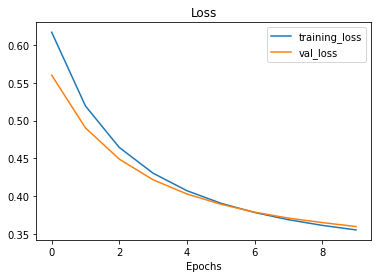

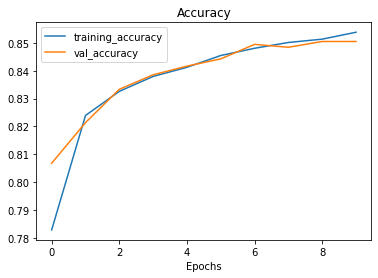

In [54]:
plot_loss_curves(history)

In [55]:
# Create our own model
model3 = tf.keras.Sequential([
   sentence_encoder_layer, # use the feature extraction layer as base
   layers.Dense(64, activation='relu'),
   layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
	]) 

In [56]:
model3.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history3 = model3.fit(train_data, epochs=10,
                    validation_data=test_data,
                    validation_steps=30,
                    callbacks=[early_stop_callbk, opt_LR_callbk])

Epoch 1/10
391/391 [==============================] - 55s 134ms/step - loss: 0.4036 - accuracy: 0.8349 - val_loss: 0.3415 - val_accuracy: 0.8516
Epoch 2/10
391/391 [==============================] - 59s 149ms/step - loss: 0.3268 - accuracy: 0.8592 - val_loss: 0.3376 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 59s 148ms/step - loss: 0.3218 - accuracy: 0.8623 - val_loss: 0.3369 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 57s 145ms/step - loss: 0.3183 - accuracy: 0.8639 - val_loss: 0.3346 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 59s 150ms/step - loss: 0.3147 - accuracy: 0.8655 - val_loss: 0.3307 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 63s 160ms/step - loss: 0.3117 - accuracy: 0.8667 - val_loss: 0.3322 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3078 - accuracy: 0.8686 - val_loss: 0.3333 - val_ac

In [58]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


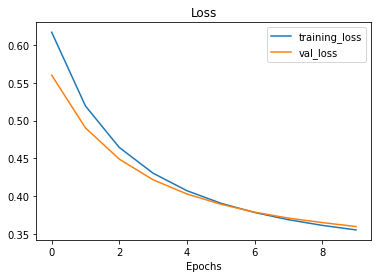

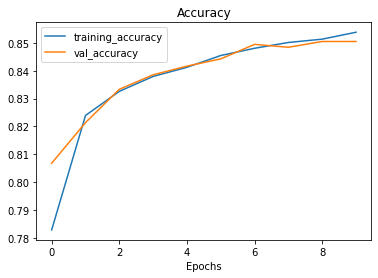

In [59]:
plot_loss_curves(history3)